In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
from torch.utils.data import Dataset
import glob
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
from google.colab import drive
drive.mount('/content/gdrive')

import zipfile
import os
zip_file = "/content/gdrive/MyDrive/base_v2.1.zip"
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

root_dir = "base_v2.1"
train_data = VisionDataset(root = os.path.join(root_dir,'train_x1'),
                         transform= transforms)
"""
print("Done")

Done


In [23]:
class My_class(Dataset):
    def __init__(self, classes_paths, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.classes = []
        self.images = []
        self.transform = transforms
        for actual_class in classes_paths:
            if actual_class == 1:
                print("")
            paths = classes_paths[actual_class]
            for path in paths:
                # print("Loading " + path)
                for top, dirs, files in os.walk(path):
                    for i, name in enumerate(files):
                        if not os.path.isfile(top + "//" + name):
                            continue
                        try:
                            imag = cv2.imread(top + "//" + name)
                        except Exception:
                            continue
                        self.images.append(imag)
                        self.classes.append(actual_class)
        self.images, self.classes = np.array(self.images), torch.tensor(np.array(self.classes), dtype=torch.int64)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform==None:
            return self.images[idx], self.classes[idx]
        else:
            return self.transform(np.array(self.images[idx]).astype(np.float32)), self.classes[idx]

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
    
    def forward(self, x):
        return self.block(x)


class CNN(nn.Module):
    def __init__(self, n_classes=31):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(1, 16),
            nn.MaxPool2d(2),
            ConvBlock(16, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            nn.Flatten()
        )
        
        cnn_out = self.model(torch.ones(1, 1, 32, 32))
        print(cnn_out.size())
        
        self.fc = nn.Sequential(
            nn.Linear(cnn_out.size()[1], 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [25]:
def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def test(model, loss_function, epochs , tag = "detection"):
    correct = 0
    total = 0
    loss_test = []
    for epoch in range(epochs):
        ep_loss = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
          # calculate outputs by running images through the network
                outputs = model(images)
                loss = loss_function(outputs, labels)
                ep_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        loss_test.append(ep_loss /len(test_loader))
        print(f"Epoch={epoch} loss={loss_test[epoch]:.4}")
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return loss_test

In [26]:
def train(model, loss_function, optimizer, epochs):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in  tqdm(train_loader): # get bacth
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model.forward(images) # call forward inside
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
        test_accuracy.append(validate(model, test_loader))
        train_accuracy.append(validate(model, train_loader))
    return test_accuracy,train_accuracy, loss_hist

In [27]:
CLASSES_PATHS = {
    0: ["base_v2.1//train_x1//SMD0402_CL//correct"],
    1: ["base_v2.1//train_x1//SMD0402_R//correct"],
    2: ["base_v2.1//train_x1//SMD0603_CL//correct"],
    3: ["base_v2.1//train_x1//SMD0603_D//correct"],
    4: ["base_v2.1//train_x1//SMD0603_R//correct"],
    5: ["base_v2.1//train_x1//SMD0805_CL//correct"],
    6: ["base_v2.1//train_x1//SMD0805_R//correct"],
    7: ["base_v2.1//train_x1//SMD1206_C//correct"],
    8: ["base_v2.1//train_x1//SMD1206_R//correct"],
    9: ["base_v2.1//train_x1//SMD1210_C//correct"],
    10: ["base_v2.1//train_x1//2-SMD//correct"],
    11: ["base_v2.1//train_x1//SMA//correct"],
    12: ["base_v2.1//train_x1//SMB//correct"],
    13: ["base_v2.1//train_x1//SOD110//correct"],
    14: ["base_v2.1//train_x1//SOD323F//correct"],
    15: ["base_v2.1//train_x1//SOD523//correct"],
    16: ["base_v2.1//train_x1//SOT23-5//correct"],
    17: ["base_v2.1//train_x1//SOT23-6//correct"],
    18: ["base_v2.1//train_x1//SOT143//correct"],
    19: ["base_v2.1//train_x1//SOT323//correct"],
    20: ["base_v2.1//train_x1//SOT323-5//correct"],
    21: ["base_v2.1//train_x1//SOT343//correct"],
    22: ["base_v2.1//train_x1//SOT363//correct"],
    23: ["base_v2.1//train_x1//SOT523//correct"],
    24: ["base_v2.1//train_x1//SOT723//correct"],
    25: ["base_v2.1//train_x1//DIP-%d//correct"],
    26: ["base_v2.1//train_x1//LQFP0.4-%d//correct"],
    27: ["base_v2.1//train_x1//LQFP0.5-%d&TFSOP-%d//correct"],
    28: ["base_v2.1//train_x1//LQFP0.8-%d//correct"],
    29: ["base_v2.1//train_x1//LQFP0.65-%d&SSOP-%d//correct"],
    30: ["base_v2.1//train_x1//SOIC-%d//correct"]
}
transforms = torchvision.transforms.Compose([ToTensor(),
                                             Grayscale(1),
                                             Resize([32, 32]),
                                             Normalize(mean=0, std=1)])

dataset = My_class(CLASSES_PATHS, transforms)

c:\python368\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [28]:
len(dataset)

8164

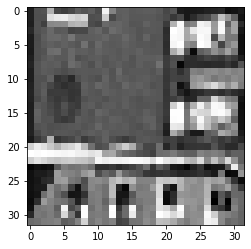

In [29]:
img, lbl = dataset[8160]
plt.imshow(img[0], cmap='gray')
plt.show()

In [30]:
param = 0.9
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [int(len(dataset) * param),
                                                                      len(dataset) - int(len(dataset) * param)])
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [31]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [33]:
model = CNN()  # Create model instance
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().cuda()
test_accuracy, train_accuracy, loss_hist = train(model, criterion, optimizer, epochs=30)

torch.Size([1, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.27it/s]


Epoch=0 loss=0.8875


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.30it/s]


Epoch=1 loss=0.3859


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.94it/s]


Epoch=2 loss=0.268


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 40.97it/s]


Epoch=3 loss=0.1874


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.82it/s]


Epoch=4 loss=0.1438


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.13it/s]


Epoch=5 loss=0.1179


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.75it/s]


Epoch=6 loss=0.1013


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 40.20it/s]


Epoch=7 loss=0.06839


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 40.12it/s]


Epoch=8 loss=0.05875


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 39.52it/s]


Epoch=9 loss=0.06043


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 40.88it/s]


Epoch=10 loss=0.05383


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 41.32it/s]


Epoch=11 loss=0.04618


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.54it/s]


Epoch=12 loss=0.05665


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 35.55it/s]


Epoch=13 loss=0.04274


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.87it/s]


Epoch=14 loss=0.05564


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 36.96it/s]


Epoch=15 loss=0.05228


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 36.35it/s]


Epoch=16 loss=0.03501


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.43it/s]


Epoch=17 loss=0.02345


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.57it/s]


Epoch=18 loss=0.02237


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.14it/s]


Epoch=19 loss=0.04296


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.36it/s]


Epoch=20 loss=0.04094


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.43it/s]


Epoch=21 loss=0.0264


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 36.93it/s]


Epoch=22 loss=0.01976


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.60it/s]


Epoch=23 loss=0.02816


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.79it/s]


Epoch=24 loss=0.03483


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.41it/s]


Epoch=25 loss=0.03054


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.36it/s]


Epoch=26 loss=0.03868


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.54it/s]


Epoch=27 loss=0.02045


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.46it/s]


Epoch=28 loss=0.01657


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.43it/s]


Epoch=29 loss=0.00888


In [34]:
validate(model, test_loader)

0.9436964504283966

In [35]:
acc_by_class = {}
if 1 not in acc_by_class:
    acc_by_class[1] = 'fdf'

In [36]:
def validate_by_class(model, dataset_test):
    acc_by_class = {}
    
    with torch.no_grad():
        model.eval()
        for image, label in dataset_test:
            outputs = model(image.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted.squeeze() == label).sum().item()
            
            if int(label) not in acc_by_class:
                acc_by_class[int(label)] = (correct, 1)
            if int(label) in acc_by_class:
                correct_prev, total_prev = acc_by_class[int(label)]
                acc_by_class[int(label)] = (correct_prev + correct, total_prev + 1)
    return acc_by_class

In [37]:
d = validate_by_class(model, dataset_test)
for key in CLASSES_PATHS.keys():
    try:
        print(CLASSES_PATHS[key], d[key])
    except:
        print(CLASSES_PATHS[key], 'NOT FOUND')

['base_v2.1//train_x1//SMD0402_CL//correct'] (199, 202)
['base_v2.1//train_x1//SMD0402_R//correct'] (119, 122)
['base_v2.1//train_x1//SMD0603_CL//correct'] (83, 89)
['base_v2.1//train_x1//SMD0603_D//correct'] (10, 11)
['base_v2.1//train_x1//SMD0603_R//correct'] (55, 56)
['base_v2.1//train_x1//SMD0805_CL//correct'] (51, 56)
['base_v2.1//train_x1//SMD0805_R//correct'] (81, 84)
['base_v2.1//train_x1//SMD1206_C//correct'] (20, 21)
['base_v2.1//train_x1//SMD1206_R//correct'] (15, 15)
['base_v2.1//train_x1//SMD1210_C//correct'] (4, 6)
['base_v2.1//train_x1//2-SMD//correct'] (4, 4)
['base_v2.1//train_x1//SMA//correct'] (10, 10)
['base_v2.1//train_x1//SMB//correct'] (5, 5)
['base_v2.1//train_x1//SOD110//correct'] (3, 4)
['base_v2.1//train_x1//SOD323F//correct'] (3, 3)
['base_v2.1//train_x1//SOD523//correct'] (3, 8)
['base_v2.1//train_x1//SOT23-5//correct'] (10, 11)
['base_v2.1//train_x1//SOT23-6//correct'] (5, 5)
['base_v2.1//train_x1//SOT143//correct'] NOT FOUND
['base_v2.1//train_x1//SOT323/

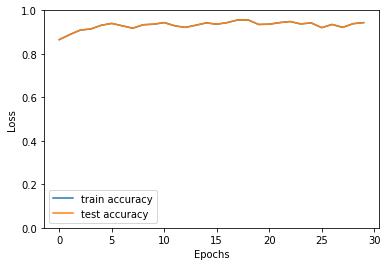

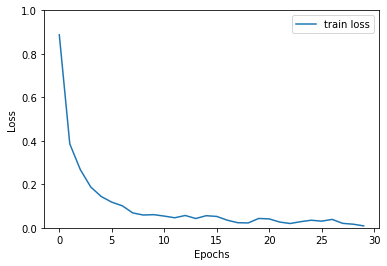

In [38]:
epochs = 30

plt.plot(range(epochs), train_accuracy, label='train accuracy')
plt.plot(range(epochs), test_accuracy, label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

epochs = 30
plt.plot(range(epochs), loss_hist, label='train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

#### Save model and try to load

In [39]:
torch.save(model.state_dict(), 'model_2022-07-25.pth')

In [40]:
# Simple test
model_eval = CNN()
model_eval.load_state_dict(torch.load('model_2022-07-25.pth'))
model_eval.eval()
model_eval(torch.rand((1, 1, 32, 32)))

torch.Size([1, 512])


tensor([[ -5.1165,  -5.0523,   3.2713,  -4.2664,  -0.4189,  -1.5843,  -4.2240,
          -7.4233,  -6.9105, -12.9677,  -4.5552,  -2.0631,  -4.8574,  -3.8231,
          -4.1092,  -9.6012,  -8.3276,  -8.0871,  -9.4825,  -7.0188,  -8.9293,
          -8.2333,  -6.7773,  -6.3463,  -5.3942,  -8.2231,  -8.3249,  -5.5265,
          -8.3823,  -5.7780,  -6.2449]], grad_fn=<AddmmBackward0>)

In [45]:
from model_info.model_info import ModelInfo

mi = ModelInfo()
mi.title = "Neural network model description format for P10"
mi.description = "This schema is computer-readable file for understand how to: prepare data," \
                   " load P10 elements classes and use threshold for PyTorch model"
mi.author = "Andrey Marakulin"
mi.start_mode = "cut32_bw"
mi.end_mode = "end_normal"
mi.model_classes = [21, 22, 23, 26, 24, 27, 29, 32, 31, 30, 17, 15, 16, 18, 19, 20, 8,
                      10, 13, 5, 9, 12, 11, 7, 14, 33, 34, 35, 36, 37, 38]

In [46]:
mi.compile_info()
scheme = mi.get_info()
model_info.save_info()

FileNotFoundError: compatible_det_info not found. How to create it see in create_compatible_det_info function.